# Calculate the scattering coefficients of a time series

This notebook demonstrates how to calculate the scattering coefficients of a time series. The example here uses `obspy` to load seismic data. One can adapt it to any time series as the loading function is arbitrary.

In [19]:
import pandas as pd
import numpy as np
import obspy 
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scatseisnet import ScatteringNetwork, signal

In [20]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load seismic 3C data
First, we load some example data from the IRIS data center. For a simple case, we load a small part (2 hours of 3C data) of the data used in the study https://doi.org/10.1029/2021JB022455. Later, the scattering network will calculate its scatterin coefficients.

In [32]:
def load_data(show=True):
    """Users: manage.
    
    Give traces as a numpy array.
    times : (n_times, )
    data: (n_channels, n_times)
    """
    
    client = Client("IRIS")
    
    stream = client.get_waveforms(network="YH",station='DC06',location='*',channel='*',starttime=UTCDateTime("2012-07-25T00:00"),endtime=UTCDateTime("2012-07-25T01:00"))
    stream.detrend("linear")
    stream.merge(method=1)
    stream.detrend("linear")
    stream.filter(type="highpass", freq=1)
    
    if show == True:
        stream.plot()
    
    # Numpyification
    times = stream[0].times("matplotlib")
    data = np.array([trace.data for trace in stream])
        
    return times, data

/home/steinmar/anaconda3/envs/ssn_api/lib/python3.10/site-packages/obspy/imaging/waveform.py:794: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.fig.subplots_adjust(hspace=0)


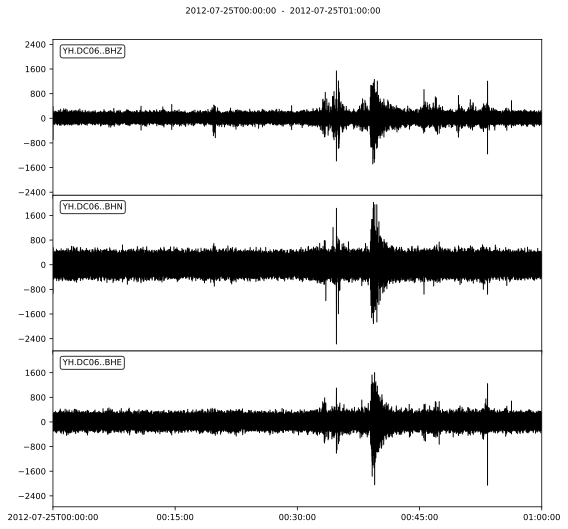

In [33]:
# Extract stream
times, data = load_data(show=True)

## Meta parameters

The following cell defines the meta parameter of the network:

- `SEGMENT` represents the window size used to chunk the data into pieces before passing it to the scattering network. We define it here in seconds since we know the data sampling rate.
-`STEP` defines the sliding duration between two consecutive windows.
- `OCTAVES` indicates the number of octaves per layer. This value can be a tuple where the number of elements defines the number of layers. 
- `RESOLUTION` represents the number of wavelets per octave (must be of the size of `OCTAVES`)
- `QUALITY` represents the quality factor of the mother wavelet (must be of the size of `OCTAVES`)
- `SAMPLING_RATE` and other values allow turning the window and stepping durations into samples. If the sampling rate is unknown, it can be turned to a reduced frequency (1) or angular frequency (2$\pi$).

Note that the type of pooling operation will be set later and not in this cell. It is not part of the network initiation.

In [21]:
SEGMENT = 60
STEP = 30
SAMPLING_RATE = 50
SAMPLES_PER_SEGMENT = int(SEGMENT * SAMPLING_RATE)
SAMPLES_PER_STEP = int(STEP * SAMPLING_RATE)
BANKS = (
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 6, "resolution": 2, "quality": 3}
)

## Network definition

We instantiate the network from the meta parameters defined in the previous cell. The following cell allows defining the scattering network graph but does not compile it. The compilation stage occurs at the first use of the network.

In [22]:
net = ScatteringNetwork(
    BANKS, bins=SAMPLES_PER_SEGMENT, sampling_rate=SAMPLING_RATE
)

## Show the filter banks

We can easily access the different properties of the network and visualize the filter banks, for instance. Note that if the notebook implements the CPU version, there is no need to transfer the data to the CPU device with the `get` method.

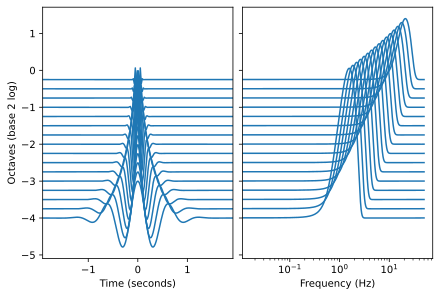

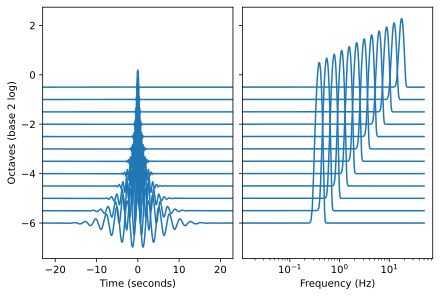

In [23]:
# Loop over network layers
for bank in net.banks:
    
    # Crete axes
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    iterable = zip(bank.wavelets, bank.spectra, bank.ratios)
    for wavelet, spectrum, ratio in iterable:
        
        # Time domain
        ax[0].plot(bank.times, wavelet.real + ratio, "C0")
    
        # Spectral domain
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()
    
    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")

## The main part: calculating the scattering coefficients

After loading some example data and initiating the scattering network, we can now caclulate the scattering coefficients. Firstly, we segmentize the continuous stream and feed these segements into the scattering network. Here we also set what kind of `POOLING` we want to use (so far we implemented maximum `max` and average pooling`avg`). Later, the scattering coefficients should be saved with `pickle`(or any other preferred serializer) in order to be used later.

In [25]:
POOLING = "max"

# Segmentization
data_segments = signal.segmentize(data, SAMPLES_PER_SEGMENT, SAMPLES_PER_STEP)
times_scat = signal.segmentize(times, SAMPLES_PER_SEGMENT, SAMPLES_PER_STEP)[:, 0]

# Scattering transform
scattering_coefficients = net.transform(data_segments, POOLING)


3 Trace(s) in Stream:
YH.DC06..BHE | 2012-07-25T00:00:00.000000Z - 2012-07-25T01:00:00.000000Z | 50.0 Hz, 180001 samples
YH.DC06..BHN | 2012-07-25T00:00:00.000000Z - 2012-07-25T01:00:00.000000Z | 50.0 Hz, 180001 samples
YH.DC06..BHZ | 2012-07-25T00:00:00.000000Z - 2012-07-25T01:00:00.000000Z | 50.0 Hz, 180001 samples


## Show some output

In the following example one can observe the scattering coefficients.

Text(0, 0.5, 'Frequency (Hz)')

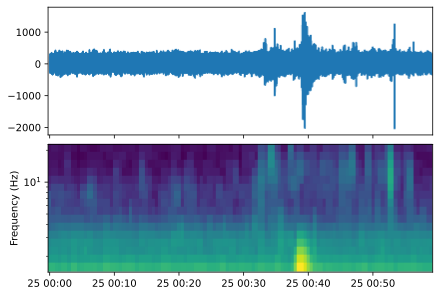

In [26]:
CHANNEL = 0

fig, ax = plt.subplots(2, sharex=True)

frequencies = net.banks[0].centers
timestamps = pd.to_datetime(times, unit="D")
timestamps_scats = pd.to_datetime(times_scat, unit="D")

first_order_scattering_coefficients = np.squeeze(scattering_coefficients[0][:, CHANNEL, :].T)
first_order_scattering_coefficients = np.log(first_order_scattering_coefficients)

ax[0].plot(timestamps, data[CHANNEL], rasterized=True)

ax[1].pcolormesh(times_scat, frequencies, first_order_scattering_coefficients, rasterized=True)
ax[1].set_yscale("log")
ax[1].set_ylabel("Frequency (Hz)")
